In [48]:
# Setup cells - not for publication

import xarray as xr
import os, sys
fn = os.path.join(os.environ['HOME'],
                  "workspace/Research/act_response/analysis/anomaly_timeseries.nc")
anomalies_ds = xr.open_dataset(fn)
anomalies_df = ds.to_dataframe().reset_index()

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-ticks', 'seaborn-talk'])

import warnings; warnings.simplefilter("ignore")

As a scientist doing much of my data analysis and visualization in Python, I'm often thankful to have access to many powerful, easy-to-use libraries. It's very rare that I'm able to think up some sort of illustration or visualization which [matplotlib](http://matplotlib.org/) can't handle. However, visualization in Python has some difficult pain points which frustrate new users and confound veterans, specifically because of matplotlib. In fact, I have never met another Pythonista who doesn't frequently visit the [matplotlib documentation](http://matplotlib.org/contents.html), even when creating simpler or mundane graphics. 

The problem, fundamentally, arises from the fact that scientific visualization has three stages:

1. Preparation of data
2. Visual encoding of data
3. Styling of visualization

It's easiest to illustrate this process with an example. 

Here, I've processed two variables from six climate model simulations. The six simulations are actually three pairs of runs with a different model configuration (the variable "**act"**) run with two different aerosol emissions scenarios (the variable "**aer**"). The two fields to the TOA radiative imbalance (*RN*) and surface temperature (*TS*). Each of the fields have been processed so the resulting timeseries is an anomaly from the long-term mean for each month, which removes the annual/seasonal cycle in the data. As a remnant of the analysis, I've left a final column in the dataset, "**month**", although this can always be inferred from the **time** column.

For illustration purposes, I pre-loaded this data into a Dataset, to make slicing-and-dicing the different timeseries easy (one could also trivially accomplish this using a DataFrame):

In [34]:
#
anomalies_ds

<xarray.Dataset>
Dimensions:  (act: 3, aer: 2, time: 900)
Coordinates:
  * act      (act) object 'arg_comp' 'pcm_gCCN3' 'nenes_comp'
  * aer      (aer) object 'PD' 'PI'
    month    (time) int32 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 ...
  * time     (time) datetime64[ns] 2001-02-01 2001-03-01 2001-04-01 ...
Data variables:
    RN       (act, aer, time) float64 1.066 -0.3007 -0.5385 0.2498 -0.5931 ...
    TS       (act, aer, time) float64 0.6699 0.3912 0.5017 0.6117 0.528 ...
Attributes:
    _NCProperties: version=1|netcdflibversion=4.4.1|hdf5libversion=1.8.17
    history: Thu Sep 01 19:28:04 2016: anomalies - concatenate data/response.arg_comp.PD/response.arg_comp.PD.TS.anomalies.nc data/response.arg_comp.PI/response.arg_comp.PI.TS.anomalies.nc data/response.arg_comp.PD/response.arg_comp.PD.RN.anomalies.nc data/response.arg_comp.PI/response.arg_comp.PI.RN.anomalies.nc data/response.pcm_gCCN3.PD/response.pcm_gCCN3.PD.TS.anomalies.nc data/response.pcm_gCCN3.PI/response.pcm_gCC

Suppose we want to create a comparison chart summarizing the timeseries in this Dataset. One such chart could have a separate panel for each model configuration **act**, showing the corresponding simulations for each **aer**. We can also add some visual cues, such as a locally-weighted average and the 0-value line. A block of code producing such a figure would look like this (with annotated comments):

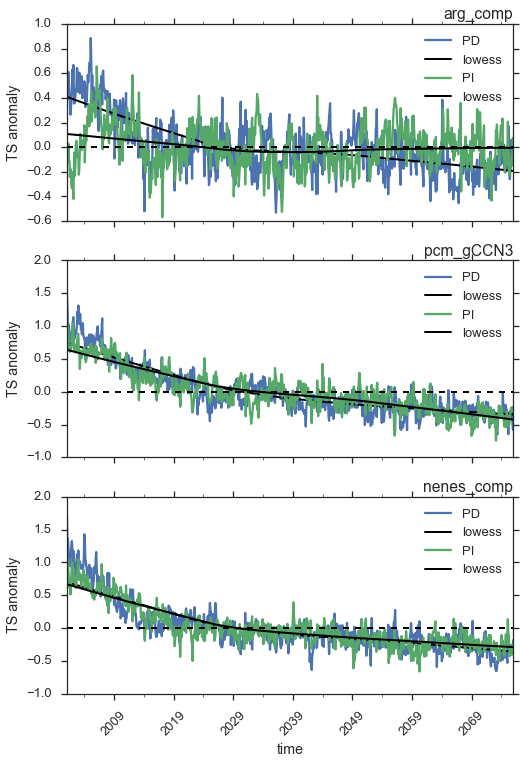

In [52]:
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

# Choose the field to plot
field = "TS"

# Set some plot/figure size dimensions
size = 4.
aspect = 2.
nrows = 3
width, height = size*aspect, nrows*size

# Create a 3-row plot, with each plot sharing an x-axis
fig, axes = plt.subplots(nrows, 1, 
                         figsize=(width, height), sharex=True)

for act, ax in zip(ds.act, axes.flat):
    act = str(act.values)
    
    for aer in ds.aer:
        aer = str(aer.values)

        resp_ts = (
            anomalies_ds[field]
            .sel(act=act, aer=aer)
            .to_dataframe(name=field)
        )
        resp_ts[field].plot(ax=ax, rot=45, label=aer)

        # Add lowess smoothed line
        x = np.arange(len(resp_ts))
        y = resp_ts[field].values
        resp_ts["lowess"] = lowess(y, x)[:,1]
        resp_ts["lowess"].plot(ax=ax, color='k', lw=2, rot=45, 
                               legend=False)
    ax.legend(loc='best')

    xlo, xhi = ax.get_xlim()
    ax.hlines(0, xlo, xhi, linestyle='dashed', lw=2, zorder=100)

    ax.set_title(act, loc='right')
    ax.set_ylabel(field + " anomaly")

There's much to be desired here:

- It would be nice to cut down on the top and right spines, to remove some of the clutter (in fact, we could just stack the three charts right on top of one-another and alternate which side the y-axis labels are on).
- The legend is a mess; we need to remove the "lowess" label (difficult, because of how we use pandas to align the fitted data) and I prefer having a text-label which is the color of the element it corresponds to (no glyph).
- Need to tweak the x-axis ticks; round numbers (5's and 10's) would be better.
- Could find someway to differentiate that smoothed fits for both **aer** cases.

But still, this is a passable plot. If you dig into the code block, though, it becomes clear that we don't have three separate phases in the visualization process - instead, we have all three mixed together. 

Our plotting logic is based around sub-selecting each individual element to plot on a given panel. This is an *extremely* low-level operation, and we have to hard-code in our foreknowledge about our data composition (what are the values of **act**, for instance) as a set of nested for-loops. The outer loop is zippered with our figure panels, explicitly encoding what each "row" in the resulting figure contains. Then, in the innermost loop, we explicitly extract a subset of our data to apply operations on (fitting the LOWESS curve). Along the way, we have to explicitly set plot aesthetics, such as adding a legend and setting labels, based on the scope of the program which contains enough information to accomplish these tasks.

While this is workable - and with enough hacking, we could make our figure look however we want - it's not really a good way to build visualizations. We have to write a lot of code and dig deep into the internals of matplotlib's API to coerce the figure into matching our expectations. Worse off, we have mix the logic of data preparation, encoding our visualization, and tweaking the aesthetics.

Locally there *is* a better way to approach a visualization of this complexity which better reflects each of the three stages as separate processes. Fundamentally, it relies on formatting your data into a ["tidy" format](http://vita.had.co.nz/papers/tidy-data.pdf), which is a tabular format where each column refers to a variable or coordinate in your dataset, and each row is a unique observation. Tidy data can easily be re-constructed from transformed into multi-dimensional formats (e.g. using a [MultiIndex in pandas](http://pandas.pydata.org/pandas-docs/stable/advanced.html) or a [DataArray in xarray](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html)) which aids in analysis and serialization, but has distinct advantages for visualization purposes as all the metadata for a given observation are encoded with its numerical value.

Once in a tidy format, your data processing is *done* - all the data necessary for properly encoding a visualization has already been setup, so you can launch directly into that second phase. From there, a second abstraction known as the ["grammar of graphics"](http://vita.had.co.nz/papers/layered-grammar.pdf) is useful. The fundamental notion behind this abstraction is to state the *structure* of a graph based on its components instead of attempting to describe the resulting composition at a high level. For instance, while it may be accurate to describe a chart as a "scatterplot", you could alternatively describe it as a set of glyphs denoting a relationship in *x*-*y*-space.

This is best illustrated with an example, for which I'll use [a Python port](http://yhat.github.io/ggplot/) of the excellent R library, [ggplot2](http://ggplot2.org/). First, we transform our Dataset into a tidy DataFrame:

In [54]:
FIELD = "TS"
data = (
    anomalies_ds[FIELD]
    .to_dataframe()
    .reset_index()
)
data.head()

,act,aer,time,TS,month
0,arg_comp,PD,2001-02-01,0.669912,2
1,arg_comp,PD,2001-03-01,0.391183,3
2,arg_comp,PD,2001-04-01,0.501736,4
3,arg_comp,PD,2001-05-01,0.611735,5
4,arg_comp,PD,2001-06-01,0.528018,6


Building the actual visualization is *really* easy afterwards:

/Users/daniel/software/ggplot/ggplot/stats/stat_smooth.py:77: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  smoothed_data = smoothed_data.sort('x')


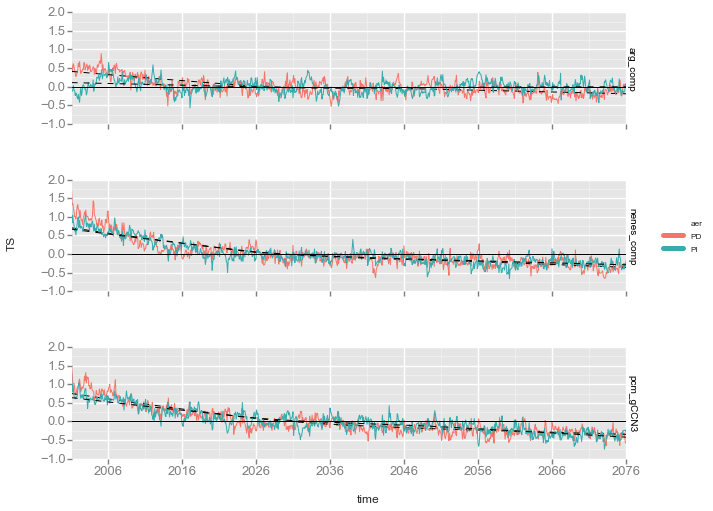

<ggplot: (-9223372036560080980)>

In [59]:
import ggplot as g
p = g.ggplot(g.aes(x='time', y=FIELD, color='aer'), data=data)
(p
  + g.geom_line() 
  + g.geom_hline(y=0, color='k', lw=2) 
  + g.facet_grid(x="act") 
  + g.stat_smooth(method='loess', linetype='dashed', color='k', se=False))

Line-by-line, here's what we're doing:

1. Import the `ggplot` library.
2. We create the basic structure of our plot by encoding *x* values to  correspond to time, *y* values to correspond to our data field, and the color to reflect which case of **aer** we're dealing with. Furthermore, we map these encodings to our tidy DataFrame.
3. Map these encodings to a "line" geometry, to connect each *x*-*y* pair.
4. Add a horizontal line to our visualization with some explicit styling and a fixed *y*-value of 0.
5. Facet this plot over the **act** case, creating one panel for each of its values.
6. Add a smoothed value to each line n our plots.

The biggest difference between this plot and our original one is that we've entirely abstracted away the details of how to parse our data set; we simply rely on the metadata mapped to each observation in it. Now, we just focus on stating *what gets plotted*, not **how to plot it.**

Things aren't 100% rosy, though. I really dislike the default theming/aesthetics in this library, and it is far from easy to customize things (As of version 0.11.2 of ggplot, you have to add a `theme` function to control element aesthetics, and you can't go back in and programmatically tweak the details of elements on the final plot). Unfortunately, ggplot doesn't yet produce matplotlib Artists for modification in this way.

Somewhere in between ggplot and matplotlib lies the plotting library [seaborn](https://web.stanford.edu/~mwaskom/software/seaborn/index.html). Seaborn is a scaffolding on top of matplotlib which enables you to more succintly - but still imperatively - build visualizations. As a simple example, 

/Users/daniel/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


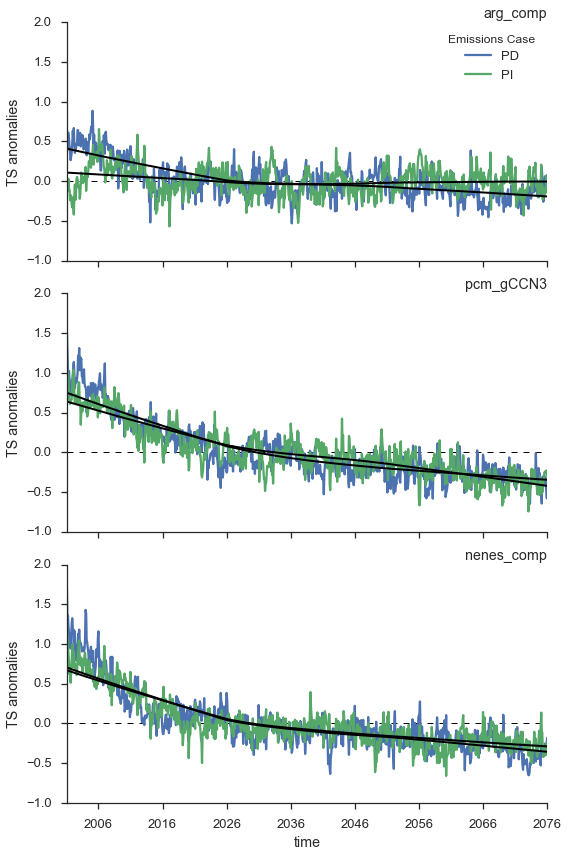

In [120]:
import seaborn as sns

# Create a faceted plot with encodings for row and line color
fg = sns.FacetGrid(data, row='act', hue='aer', size=4, aspect=2.,
                   legend_out=False)
# Use the matplotlib "plot" function, encoding x="time" and y=FIELD
fg.map(plt.plot, 'time', FIELD)

# Define a function to compute the smoothed line,
# and have seaborn apply it to each element in the facetted plot
def _smoothed(*args, **kwargs):
    x, y = args[0], args[1]
    xx = np.arange(len(x))
    yy = y.values
    fit = lowess(yy, xx)[:,1]
    kwargs.update({'label': None})
    plt.plot(x, fit, **kwargs)
fg.map(_smoothed, 'time', FIELD, color='k', lw=2)    

# Add legend based on current plot data
fg.add_legend(title="Emissions Case")

# Set some plot aesthetics
fg.set_titles("")
fg.set_titles(row_template="{row_name}", loc='right')
fg.set_ylabels(label="{} anomalies".format(FIELD))
for ax in fg.axes.flat:
    xlo, xhi = ax.get_xlim()
    ax.hlines(0, xlo, xhi, lw=1, linestyle='dashed', color='k')

This isn't as succinct as the ggplot example, but it does vastly improve upon the original matplotlib construction by relying on abstractions for the plot composition and the notion of "mapping" functions to the data.

In the Python ecosystem, I think this comes the closest to purely matching the three stages of visualization. Clearly, data preparation is entirely abstracted away here; the data has to be pre-processed for seaborn to even play with it nicely. But where it mingles the encoding and aesthetic stages, it still provides many hooks for digging in with matplotlib to hand-tweak the plot elements. Thus, seaborn remains my go-to for plotting, by providing a convenient way to abstract away much of the machinery of matplotlib, while still affording the opportunity to hand-craft the aesthetics of the resulting plots.

## The Future

However, I'm optimistic about some upcoming tools. In particular, a newcomer on the scene is [altair](https://github.com/ellisonbg/altair). Fundamentally, altair aims to purely accomplish the visual encoding phase of generating graphics:

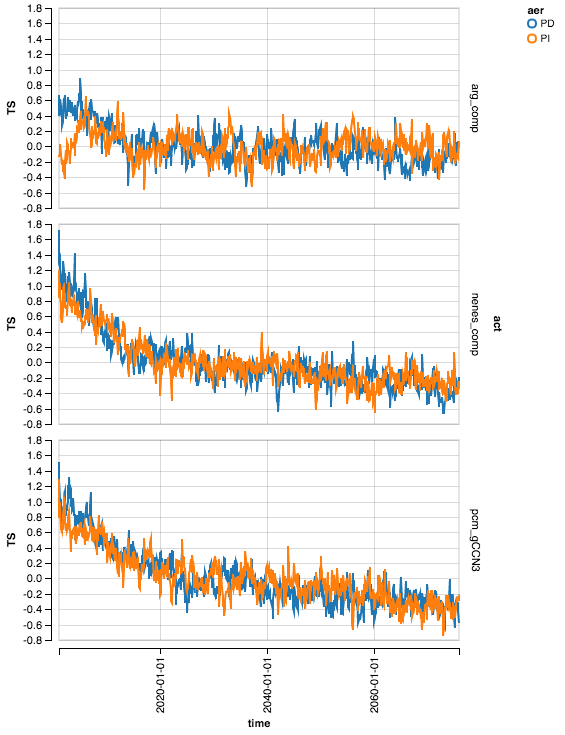

In [121]:
from altair import Chart

Chart(data).mark_line().encode(
    x='time:T', y=FIELD, color='aer',
    row='act'
).configure_cell(width=400, height=200)

Now, this is hardly a finalized chart, but that's partially because altair doesn't yet expose a convenient way to add the additional plot elements we would want. For instance, we could add smoothing, but that would require abstracting away the `Chart` class in altair, and building a lot of machinery. At some point in the future, when libraries or extensions for this functionality exist, that'll be a great addition to have.

But where altair will really shine is when matplotlib offers an implementation of the vega-lite plot encoding that altair generates. If the above function returned a  `Figure` and a set of `Axis` instances, then we could programatically make any aesthetic tweaks we wanted; in fact, we could write simple programs to automate this styling, or we could explicitly impose it at the matplotlib rcParams level.

Someday in the future, we'll have this to look forward to!